In [1]:
BATCH_SIZE = 32
MAX_LEN = 512
EMBEDDING_DIMS = 300

In [2]:
import tensorflow as tf

def parse(example):
    features = tf.parse_single_example(
        example,
        features={
            'X': tf.FixedLenFeature([MAX_LEN, EMBEDDING_DIMS], dtype=tf.float32),
            'Y': tf.FixedLenFeature((9,), dtype=tf.float32)
        })
    
    X = features['X']
    Y = features['Y']
    
    return X, Y

In [3]:
def iterator(tfrecord_path, data_len):
    dataset = tf.data.TFRecordDataset([tfrecord_path]).map(parse)
    dataset = dataset.repeat(-1).batch(data_len)
    iterator = dataset.make_one_shot_iterator()

    X, Y = iterator.get_next()
    X = tf.reshape(X, [-1, MAX_LEN, EMBEDDING_DIMS])
    
    return X, Y

In [4]:
%%time

x_train, y_train = iterator('train.tfrecord', 5893)
x_test, y_test = iterator('test.tfrecord', 1474)

x_train = tf.Session().run(x_train)
y_train = tf.Session().run(y_train)
x_test = tf.Session().run(x_test)
y_test = tf.Session().run(y_test)

CPU times: user 24.8 s, sys: 4.22 s, total: 29 s
Wall time: 28.3 s


In [5]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((5893, 512, 300), (5893, 9), (1474, 512, 300), (1474, 9))

In [6]:
hidden_dims = 50
epochs = 5

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten
from keras.layers.wrappers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(hidden_dims, return_sequences=True),
                            input_shape=(MAX_LEN, EMBEDDING_DIMS)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(9, activation='softmax'))

model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 512, 100)          140400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512, 100)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 460809    
Total params: 601,209
Trainable params: 601,209
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.optimizers import Adam

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy'])

In [10]:
%%time

hist = model.fit(x_train,
                 y_train,
                batch_size=BATCH_SIZE,
                epochs=epochs,
                validation_data=(x_test, y_test))

Train on 5893 samples, validate on 1474 samples
Epoch 1/5
5893/5893 [==============================] - 439s 74ms/step - loss: 0.6673 - acc: 0.7738 - val_loss: 0.5149 - val_acc: 0.8406
Epoch 2/5
5893/5893 [==============================] - 440s 75ms/step - loss: 0.1229 - acc: 0.9647 - val_loss: 0.4324 - val_acc: 0.8575
Epoch 3/5
5893/5893 [==============================] - 443s 75ms/step - loss: 0.0300 - acc: 0.9932 - val_loss: 0.4487 - val_acc: 0.8738
Epoch 4/5
5893/5893 [==============================] - 437s 74ms/step - loss: 0.0113 - acc: 0.9985 - val_loss: 0.4084 - val_acc: 0.8901
Epoch 5/5
5893/5893 [==============================] - 435s 74ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.4269 - val_acc: 0.8908
CPU times: user 1h 6min 36s, sys: 16min 11s, total: 1h 22min 47s
Wall time: 36min 36s


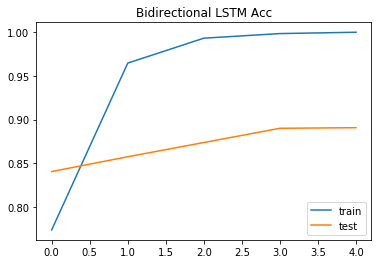

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Bidirectional LSTM Acc')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

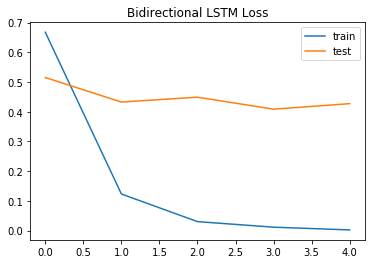

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Bidirectional LSTM Loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [13]:
import numpy as np

pred_values_orig = model.predict(x_test)
pred_values = np.argmax(pred_values_orig, axis=1)
print('shape of pred_values:', pred_values.shape)
y_test = np.argmax(y_test, axis=1)
print('shape of y_test:', y_test.shape)

shape of pred_values: (1474,)
shape of y_test: (1474,)


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['dokujo-tsushin', 'it-life-hack', 'kaden-channel',\
                'livedoor-homme', 'movie-enter', 'peachy', 'smax',\
                'sports-watch', 'topic-news']

result = classification_report(y_test, pred_values, digits=3, target_names=target_names)

print(result)

                precision    recall  f1-score   support

dokujo-tsushin      0.799     0.886     0.840       175
  it-life-hack      0.858     0.903     0.880       154
 kaden-channel      0.913     0.940     0.926       167
livedoor-homme      0.826     0.623     0.710       114
   movie-enter      0.876     0.977     0.924       174
        peachy      0.840     0.772     0.805       184
          smax      0.962     0.946     0.954       186
  sports-watch      0.957     0.957     0.957       163
    topic-news      0.974     0.936     0.955       157

     micro avg      0.891     0.891     0.891      1474
     macro avg      0.889     0.882     0.883      1474
  weighted avg      0.891     0.891     0.889      1474



Normalized confusion matrix
[[0.886 0.011 0.    0.023 0.017 0.051 0.    0.006 0.006]
 [0.013 0.903 0.032 0.006 0.006 0.013 0.019 0.006 0.   ]
 [0.    0.024 0.94  0.    0.    0.024 0.012 0.    0.   ]
 [0.079 0.079 0.044 0.623 0.079 0.079 0.009 0.009 0.   ]
 [0.011 0.    0.    0.006 0.977 0.006 0.    0.    0.   ]
 [0.13  0.011 0.    0.038 0.038 0.772 0.005 0.005 0.   ]
 [0.    0.027 0.022 0.    0.    0.005 0.946 0.    0.   ]
 [0.006 0.    0.    0.006 0.012 0.    0.    0.957 0.018]
 [0.006 0.006 0.006 0.006 0.013 0.006 0.    0.019 0.936]]


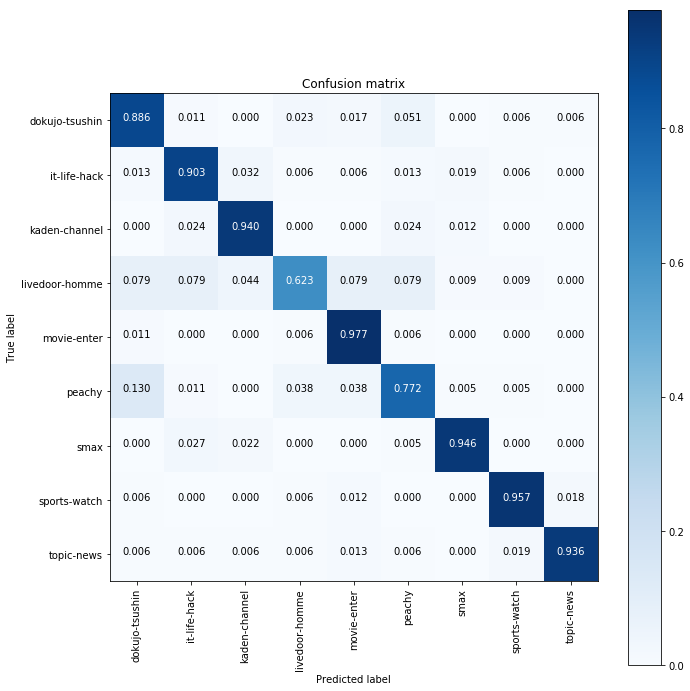

In [15]:
from plot_graph import plot_confusion_matrix
%matplotlib inline
from pylab import rcParams

rcParams['figure.figsize'] = 10,10

conf_mat = confusion_matrix(y_test, pred_values)
plot_confusion_matrix(conf_mat, target_names, normalize=True)